
#### Running a few different NLP models to understand customer concerns in the ski industry.

#### Questions:


### Imports

In [20]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
from transformers import pipeline
from summa import keywords
from collections import Counter




# For using with google collab
# from google.colab import drive
# drive.mount('/content/drive')



### Loading Dataset

In [3]:

# Read the CSV file
#file_path = 'C:/Users/johne/Downloads/OnTheSnow_SkiAreaReviews.csv'
file_path = 'C:/Users/matt/Downloads/OnTheSnow_SkiAreaReviews.csv'
skiraw = pd.read_csv(file_path)
print(skiraw.head())

# Filter out unwanted columns
skiraw2 = skiraw[['State', 'Ski Area', 'Review Star Rating (out of 5)', 'Review Text']]

# Display the first few rows of the new DataFrame to verify
print(skiraw2.head())

   Unnamed: 0       State          Ski Area  Reviewer Name  \
0           0  california  squaw-valley-usa  philip sayles   
1           1  california  squaw-valley-usa    mateonelson   
2           2  california  squaw-valley-usa            NaN   
3           3  california  squaw-valley-usa   Ivan Cazares   
4           4  california  squaw-valley-usa        welzbob   

          Review Date  Review Star Rating (out of 5)  \
0  31st December 2019                              3   
1       22nd May 2019                              4   
2      7th March 2019                              2   
3      5th March 2019                              3   
4  26th February 2019                              3   

                                         Review Text  
0  I'm glad our family experienced Squaw but I wo...  
1  I went skiing today 5/22, granite chief was am...  
2  We had a horrible experience on our family ski...  
3  This is the first year I ski Squaw. I've been ...  
4  Both Squaw a

### Cleaning Data

In [4]:
# Check for null values
null_values = skiraw2.isnull().sum()
print("Null values in each column:\n", null_values)

# Remove reviews without text because this is NLP based
ski_cleaned = skiraw2.dropna(subset=['Review Text'])

# Check for Null values again
null_values = ski_cleaned.isnull().sum()
print("Null values in each column:\n", null_values)

# Convert review text column to string
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)

# Verify the conversion
print(ski_cleaned['Review Text Cleaned'].dtype)


Null values in each column:
 State                             0
Ski Area                          0
Review Star Rating (out of 5)     0
Review Text                      12
dtype: int64
Null values in each column:
 State                            0
Ski Area                         0
Review Star Rating (out of 5)    0
Review Text                      0
dtype: int64
object


C:\Users\matt\AppData\Local\Temp\ipykernel_7216\3606133100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)


## Visualizing Raw Data

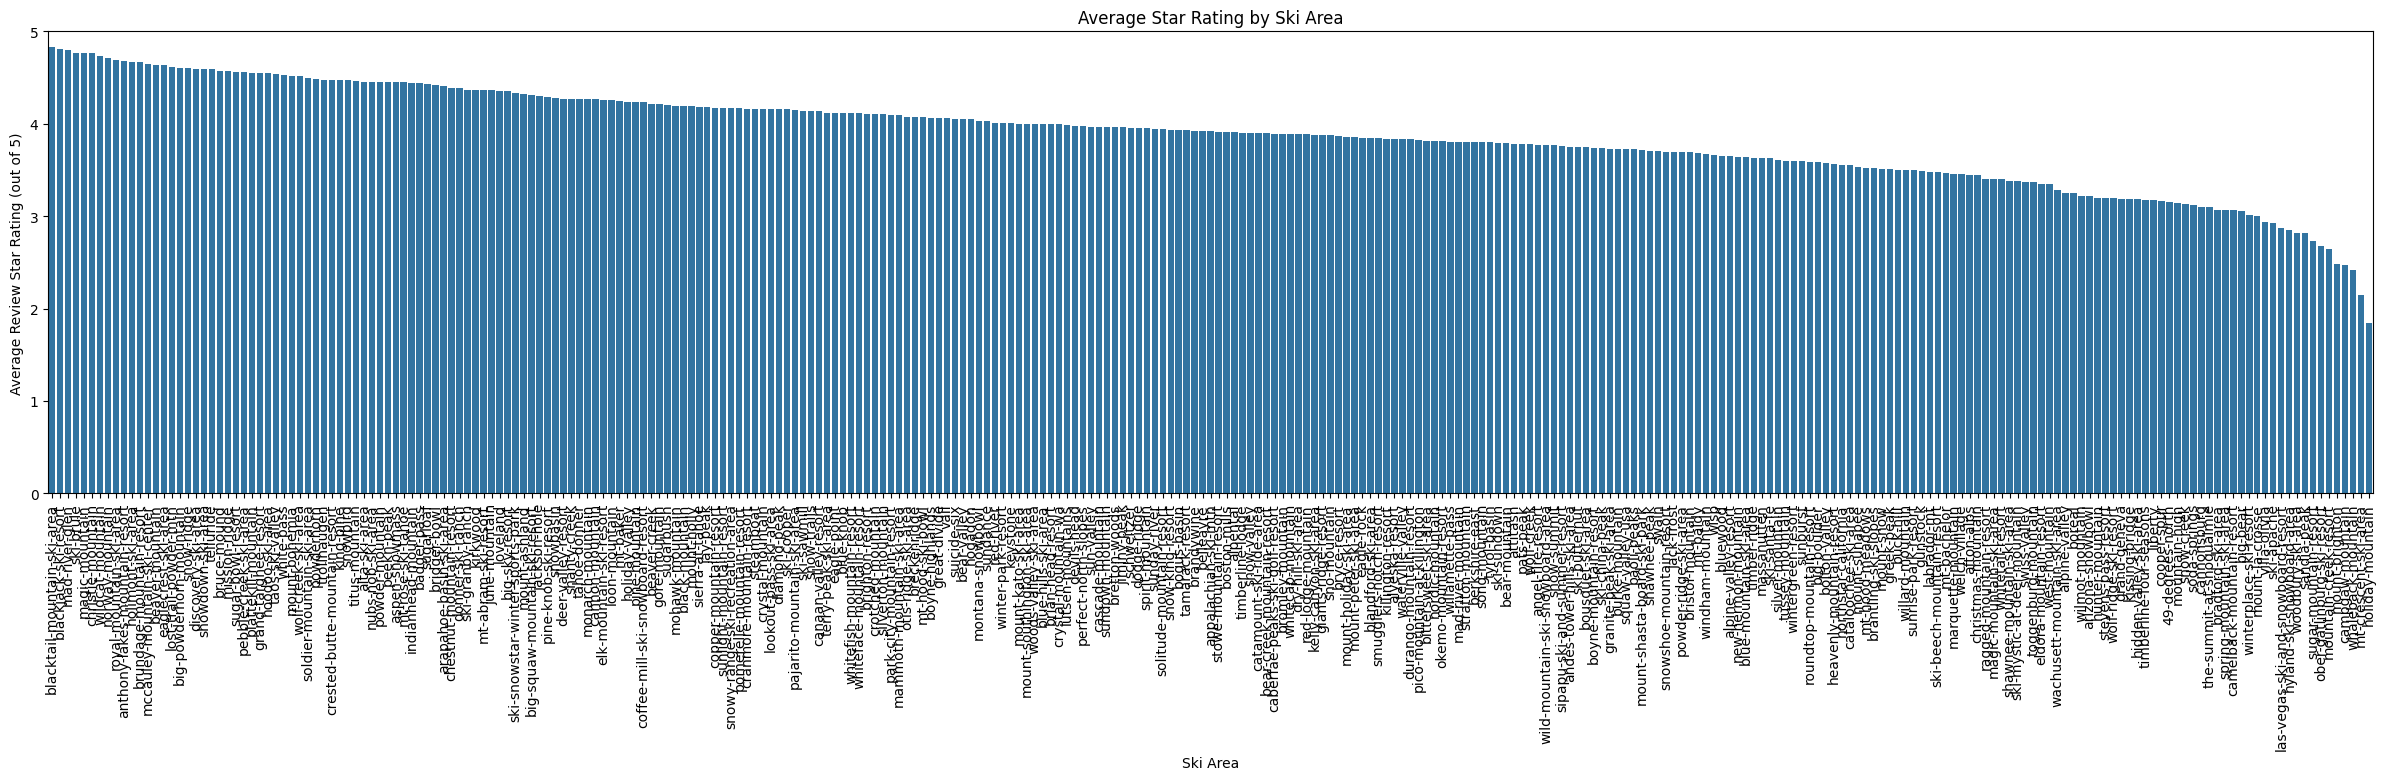

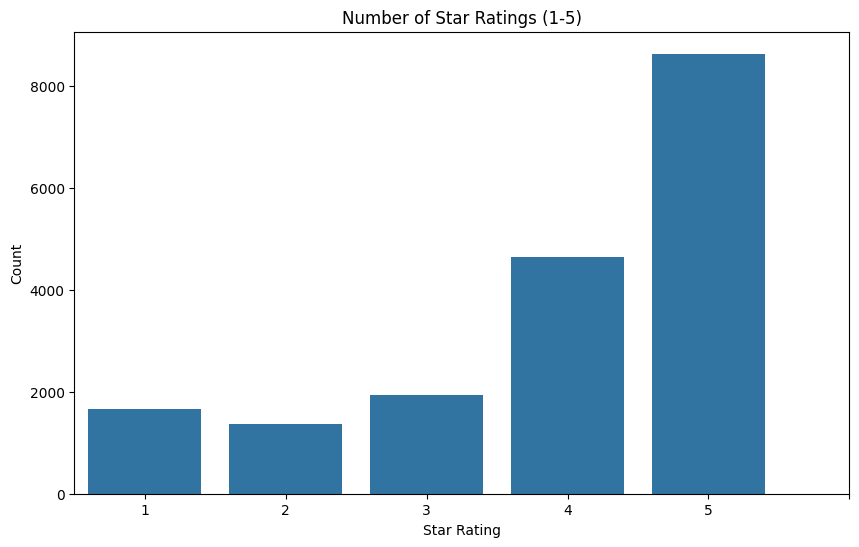

In [5]:
# Bar plot for the average star rating by ski area, sorted by descending order
plt.figure(figsize=(30, 6))
average_ratings = ski_cleaned.groupby('Ski Area')['Review Star Rating (out of 5)'].mean().reset_index()
average_ratings = average_ratings.sort_values(by='Review Star Rating (out of 5)', ascending=False)
sns.barplot(data=average_ratings, x='Ski Area', y='Review Star Rating (out of 5)')
plt.title('Average Star Rating by Ski Area')
plt.xlabel('Ski Area')
plt.ylabel('Average Review Star Rating (out of 5)')
plt.ylim(0, 5)
plt.xticks(rotation=90)
plt.show()

# Plot the number of star ratings from 1 to 5
plt.figure(figsize=(10, 6))
sns.countplot(data=ski_cleaned, x='Review Star Rating (out of 5)')
plt.title('Number of Star Ratings (1-5)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.show()

### Takeaways
- Every ski resort has an average of above 2 stars
- The distibution of review star ratings leans heavily towards positive ratings

## Extracting Positive and Negative Features Using Sentiment Analysis

### Data cleaning for sentiment Analysis

In [6]:
# Data cleaning for sentiment analysis
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('[^\w\s]', '', regex=True)
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\d+', '', regex=True)
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.lower()

# Remove stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Tokenize text
nltk.download('punkt')
ski_cleaned['tokens'] = ski_cleaned['Review Text Cleaned'].apply(word_tokenize)

# Lemmatize tokens
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

ski_cleaned['tokens'] = ski_cleaned['tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])

# Join tokens back to a string
ski_cleaned['final_text'] = ski_cleaned['tokens'].apply(lambda x: ' '.join(x))


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\matt\AppData\Local\Temp\ipykernel_7216\2467288695.py:2: SyntaxWarning: invalid escape sequence '\w'
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('[^\w\s]', '', regex=True)
C:\Users\matt\AppData\Local\Temp\ipykernel_7216\2467288695.py:3: SyntaxWarning: invalid escape sequence '\d'
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\d+', '', regex=True)
C:\Users\matt\AppData\Local\Temp\ipykernel_7216\2467288695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_c

### Running Seniment On Tokens using pre-trained model for labeling

In [7]:
# Using Transformers for sentiment
from transformers import pipeline

# Initialize the sentiment analysis pipeline with a specific model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

# Truncate text tokens to avoid runtime errors
max_length = 396

# Function to truncate text
def truncate_text(text, max_length):
    tokens = word_tokenize(text)
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    return ' '.join(tokens)

# Apply the truncation function to the final_text
ski_cleaned['final_text_truncated'] = ski_cleaned['final_text'].apply(lambda x: truncate_text(x, max_length))

# Verify truncation
print(ski_cleaned['final_text_truncated'].apply(lambda x: len(word_tokenize(x))).max())

# Apply the pipeline to the data
chunk_size = 500  # Adjust this size based on your system's capabilities
results = []
for i in range(0, len(ski_cleaned['final_text_truncated']), chunk_size):
    chunk = ski_cleaned['final_text_truncated'][i:i+chunk_size]
    results.extend(sentiment_pipeline(chunk.tolist()))

# Add Transformers sentiment results to the dataframe
ski_cleaned['transformers_sentiment'] = [result['label'] for result in results]
ski_cleaned['transformers_score'] = [result['score'] for result in results]

# Print the head of the cleaned dataframe
print(ski_cleaned.head())

C:\Users\matt\AppData\Local\Temp\ipykernel_7216\2574230296.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['final_text_truncated'] = ski_cleaned['final_text'].apply(lambda x: truncate_text(x, max_length))


396
        State          Ski Area  Review Star Rating (out of 5)  \
0  california  squaw-valley-usa                              3   
1  california  squaw-valley-usa                              4   
2  california  squaw-valley-usa                              2   
3  california  squaw-valley-usa                              3   
4  california  squaw-valley-usa                              3   

                                         Review Text  \
0  I'm glad our family experienced Squaw but I wo...   
1  I went skiing today 5/22, granite chief was am...   
2  We had a horrible experience on our family ski...   
3  This is the first year I ski Squaw. I've been ...   
4  Both Squaw and Alpine have incredible terrain,...   

                                 Review Text Cleaned  \
0  im glad family experienced squaw wont return n...   
1  went skiing today granite chief amazing new sn...   
2  horrible experience family ski vacation plenty...   
3  first year ski squaw ive couple sun

C:\Users\matt\AppData\Local\Temp\ipykernel_7216\2574230296.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['transformers_sentiment'] = [result['label'] for result in results]
C:\Users\matt\AppData\Local\Temp\ipykernel_7216\2574230296.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['transformers_score'] = [result['score'] for result in results]


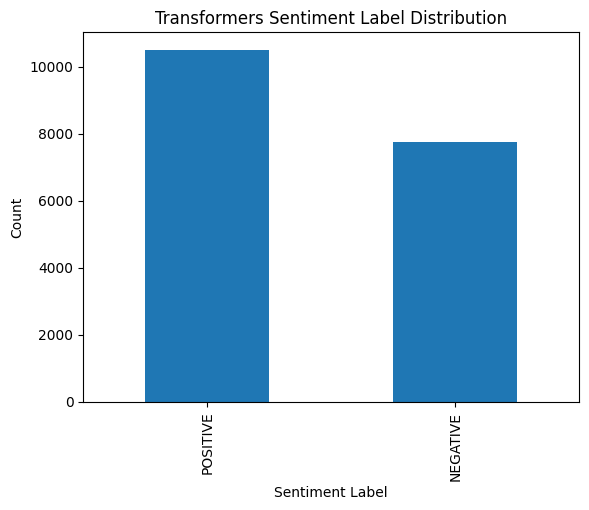

In [8]:


# Display sentiment label distribution for Transformers
ski_cleaned['transformers_sentiment'].value_counts().plot(kind='bar')
plt.title('Transformers Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [9]:
ski_cleaned.head()

,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned,tokens,final_text,final_text_truncated,transformers_sentiment,transformers_score
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,im glad family experienced squaw wont return n...,"[im, glad, family, experienced, squaw, wont, r...",im glad family experienced squaw wont return n...,im glad family experienced squaw wont return n...,NEGATIVE,0.995032
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...",went skiing today granite chief amazing new sn...,"[go, skiing, today, granite, chief, amaze, new...",go skiing today granite chief amaze new snow c...,go skiing today granite chief amaze new snow c...,POSITIVE,0.984520
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation plenty...,"[horrible, experience, family, ski, vacation, ...",horrible experience family ski vacation plenty...,horrible experience family ski vacation plenty...,NEGATIVE,0.993395
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw ive couple sunny powder d...,"[first, year, ski, squaw, ive, couple, sunny, ...",first year ski squaw ive couple sunny powder d...,first year ski squaw ive couple sunny powder d...,NEGATIVE,0.975237
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...",squaw alpine incredible terrain impressive sno...,"[squaw, alpine, incredible, terrain, impressiv...",squaw alpine incredible terrain impressive sno...,squaw alpine incredible terrain impressive sno...,NEGATIVE,0.908184


### Counting number of skiing relted keywords in text while considering next steps

In [15]:
# Occurances of word associated with chairlift

# Define the words you want to count
words_to_count = ["chairlift", "chair"]

# Function to count occurrences of words in a string
def count_words_occurrences(text, words):
    return sum(text.split().count(word) for word in words)

# Count occurrences of the words in the 'final_text' column
total_count = ski_cleaned['final_text'].apply(lambda x: count_words_occurrences(x, words_to_count)).sum()

# Print the result
print(f"The words {words_to_count} occur {total_count} times in the 'final_text' column.")

# Function to count occurrences of a word in a string
def count_word_occurrences(text, word):
    return text.split().count(word)

# Occurances of the word food

# Apply the function to the 'final_text' column and sum the results
word_count_food = ski_cleaned['final_text'].apply(lambda x: count_word_occurrences(x, "food")).sum()

print(f"The word '{"food"}' occurs {word_count_food} times in the 'final_text' column.")


# Occurances of the word Hotel

# Apply the function to the 'final_text' column and sum the results
word_count_skiing = ski_cleaned['final_text'].apply(lambda x: count_word_occurrences(x, "hotel")).sum()

print(f"The word '{"hotel"}' occurs {word_count_food} times in the 'final_text' column.")


# Occurances of the word skiing

# Apply the function to the 'final_text' column and sum the results
word_count_skiing = ski_cleaned['final_text'].apply(lambda x: count_word_occurrences(x, "skiing")).sum()

print(f"The word '{"skiing"}' occurs {word_count_skiing} times in the 'final_text' column.")

The words ['chairlift', 'chair'] occur 2168 times in the 'final_text' column.
The word 'food' occurs 2549 times in the 'final_text' column.
The word 'hotel' occurs 593 times in the 'final_text' column.
The word 'skiing' occurs 7838 times in the 'final_text' column.


### Conducting Keyword Extraction on Negative and Positive reviews seperately to gain insight

C:\Users\matt\AppData\Local\Temp\ipykernel_7216\3190869356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['keywords'] = negative_reviews['final_text'].apply(lambda x: keywords.keywords(x).split('\n'))


      keyword  count
4         ski   1692
8      skiing   1291
29       lift   1051
28   mountain    950
100      snow    803
14        run    779
9         day    748
43     resort    623
46      great    557
68      place    539
17       time    482
81       like    469
120      good    463
121   terrain    442
101     trail    415
125      make    374
479      park    362
109    people    351
433      area    348
176      line    348


C:\Users\matt\AppData\Local\Temp\ipykernel_7216\3190869356.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['keywords'] = positive_reviews['final_text'].apply(lambda x: keywords.keywords(x).split('\n'))


      keyword  count
1         ski   1634
15      great   1445
164    skiing   1251
9               1124
4    mountain    822
23       snow    668
24       good    622
26      place    609
48        run    561
114      lift    559
72        day    533
5      resort    514
7     terrain    401
39       year    342
161      time    337
333    family    329
99       best    301
497     trail    294
21       area    271
159  friendly    260


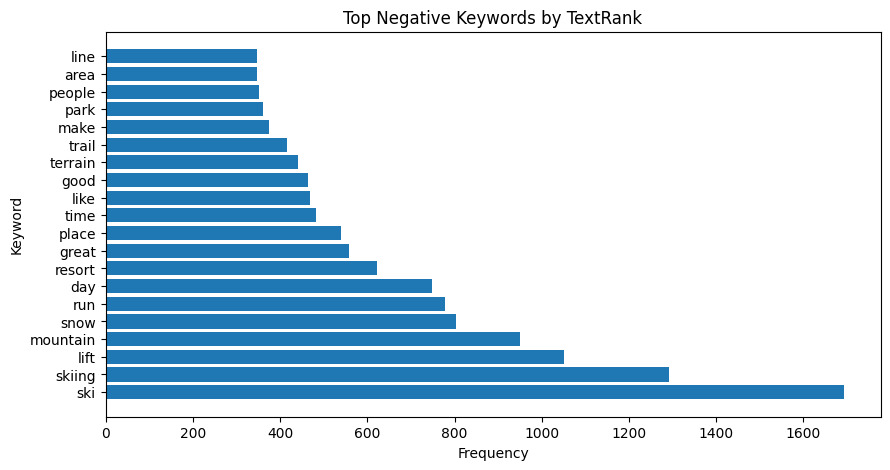

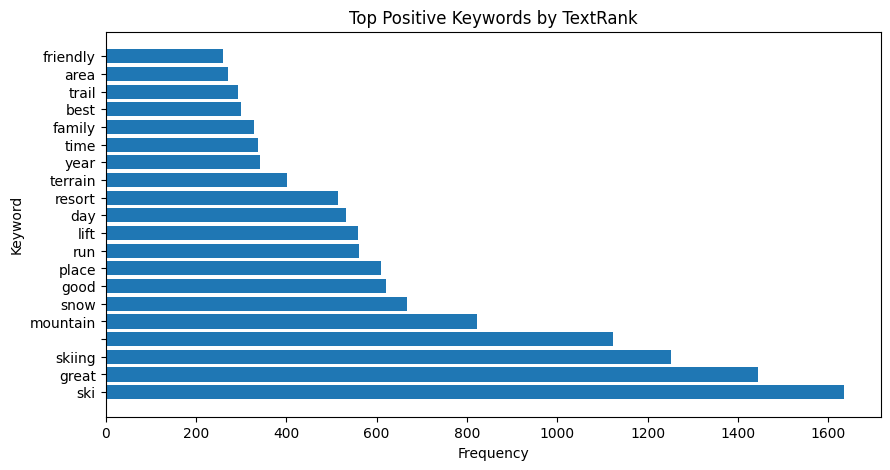

In [22]:
# Filter the DataFrame to only include rows where 'transformers_sentiment' is 'NEGATIVE'
negative_reviews = ski_cleaned[ski_cleaned['transformers_sentiment'] == 'NEGATIVE']

# Apply TextRank to each negative review
negative_reviews['keywords'] = negative_reviews['final_text'].apply(lambda x: keywords.keywords(x).split('\n'))

# Flatten the list of keywords
all_keywords_neg = [keyword for sublist in negative_reviews['keywords'] for keyword in sublist]

# Get the frequency distribution of keywords
keyword_freq_neg = Counter(all_keywords_neg)

# Convert to DataFrame
keywords_df_neg = pd.DataFrame(keyword_freq_neg.items(), columns=['keyword', 'count'])

# Sort the DataFrame by count in descending order
keywords_df_neg = keywords_df_neg.sort_values(by='count', ascending=False)

# Display the top keywords
print(keywords_df_neg.head(20))


# Filter the DataFrame to only include rows where 'transformers_sentiment' is 'POSITIVE'
positive_reviews = ski_cleaned[ski_cleaned['transformers_sentiment'] == 'POSITIVE']

# Apply TextRank to each negative review
positive_reviews['keywords'] = positive_reviews['final_text'].apply(lambda x: keywords.keywords(x).split('\n'))

# Flatten the list of keywords
all_keywords_pos = [keyword for sublist in positive_reviews['keywords'] for keyword in sublist]

# Get the frequency distribution of keywords
keyword_freq_pos = Counter(all_keywords_pos)

# Convert to DataFrame
keywords_df_pos = pd.DataFrame(keyword_freq_pos.items(), columns=['keyword', 'count'])

# Sort the DataFrame by count in descending order
keywords_df_pos = keywords_df_pos.sort_values(by='count', ascending=False)

# Display the top keywords
print(keywords_df_pos.head(20))

# Visualization
plt.figure(figsize=(10, 5))
plt.barh(keywords_df_neg['keyword'][:20], keywords_df_neg['count'][:20])
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top Negative Keywords by TextRank')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(keywords_df_pos['keyword'][:20], keywords_df_pos['count'][:20])
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top Positive Keywords by TextRank')
plt.show()